In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
ROOT = '.data'

train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 22.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 608kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.57MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.3MB/s]


In [4]:
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

In [5]:
print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

Calculated mean: 0.13066047430038452
Calculated std: 0.30810779333114624


In [6]:
train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

In [7]:
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

In [8]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 60000
Number of testing examples: 10000


In [9]:
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

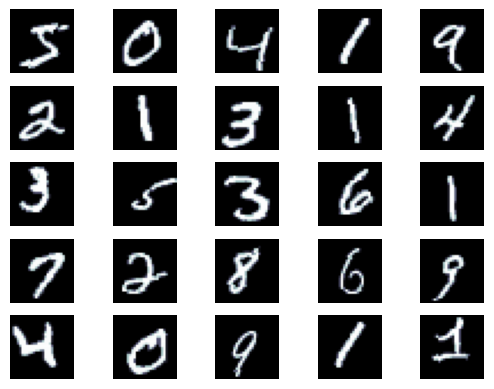

In [10]:
N_IMAGES = 25

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]

plot_images(images)

In [11]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

In [12]:
train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

In [13]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


In [15]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [16]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

In [17]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, activation_type='relu'): # added activation_type
        super().__init__()
        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)
        self.activation_type = activation_type # save

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        # Activation control
        if self.activation_type == 'sigmoid':
            act = torch.sigmoid
        else:
            act = F.relu

        h_1 = act(self.input_fc(x))
        h_2 = act(self.hidden_fc(h_1)) # h_2 stored for PCA
        y_pred = self.output_fc(h_2)

        return y_pred, h_2

In [18]:
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    # MSE check
    is_mse = isinstance(criterion, nn.MSELoss)

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            if is_mse:
                # transormations for MSE
                #y_prob = F.softmax(y_pred, dim=1)
                y_one_hot = F.one_hot(y, num_classes=10).float()
                loss = criterion(y_pred, y_one_hot)
            else:
                loss = criterion(y_pred, y)

            # Accuracy
            top_pred = y_pred.argmax(1, keepdim=True)
            correct = top_pred.eq(y.view_as(top_pred)).sum()
            acc = correct.float() / y.shape[0]

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def train_epoch(model, iterator, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    # Check if the criterion is MSE or not
    is_mse = isinstance(criterion, nn.MSELoss)

    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred, _ = model(x) # _ = intermediate layer

        if is_mse:
            # One-Hot Encoding and Softmax for MSE
            #y_prob = F.softmax(y_pred, dim=1)
            y_one_hot = F.one_hot(y, num_classes=10).float()
            loss = criterion(y_pred, y_one_hot)
        else:
            # CrossEntropy
            loss = criterion(y_pred, y)

        # Accuracy
        top_pred = y_pred.argmax(1, keepdim=True)
        correct = top_pred.eq(y.view_as(top_pred)).sum()
        acc = correct.float() / y.shape[0]

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def get_test_data_for_plots(model, iterator, device):
    """PCA ve Confusion Matrix için verileri toplar"""
    model.eval()
    intermediates = []
    labels = []
    preds = []

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred, h_2 = model(x) # h_2: 2nd hidden layer (100 neuron)

            # Predictions
            y_prob = F.softmax(y_pred, dim=-1)
            top_pred = y_prob.argmax(1, keepdim=True)

            intermediates.append(h_2.cpu())
            labels.append(y.cpu())
            preds.append(top_pred.cpu())

    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)
    preds = torch.cat(preds, dim=0)
    return intermediates, labels, preds

Starting experiments for 16 cases...

--- Case 1/16: relu_8_cross_entropy_sgd ---
  Result -> Train Acc: 92.53% | Best Valid Loss: 0.163 | Best Valid Acc: 95.37% | Test Acc: 95.93%


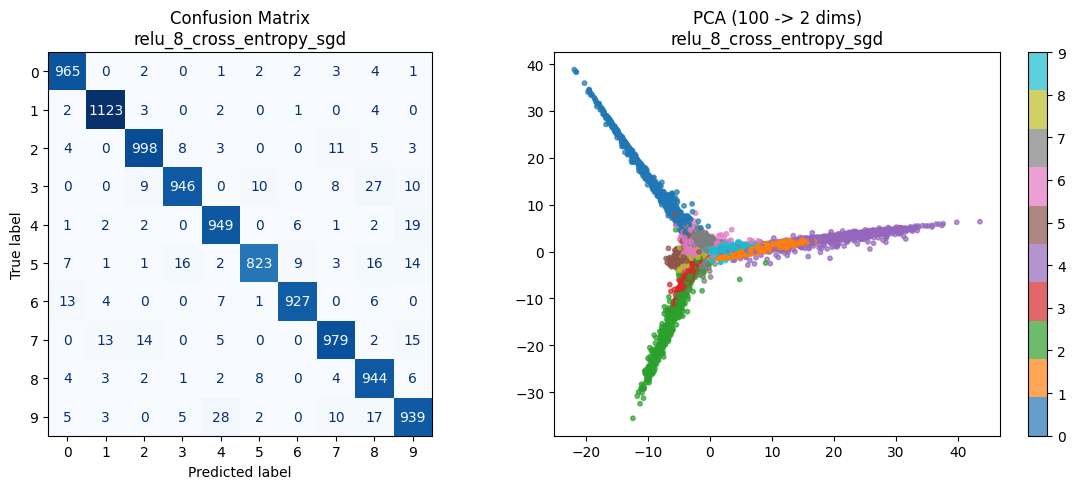

--- Case 2/16: relu_8_cross_entropy_adam ---
  Result -> Train Acc: 96.52% | Best Valid Loss: 0.084 | Best Valid Acc: 97.23% | Test Acc: 97.90%


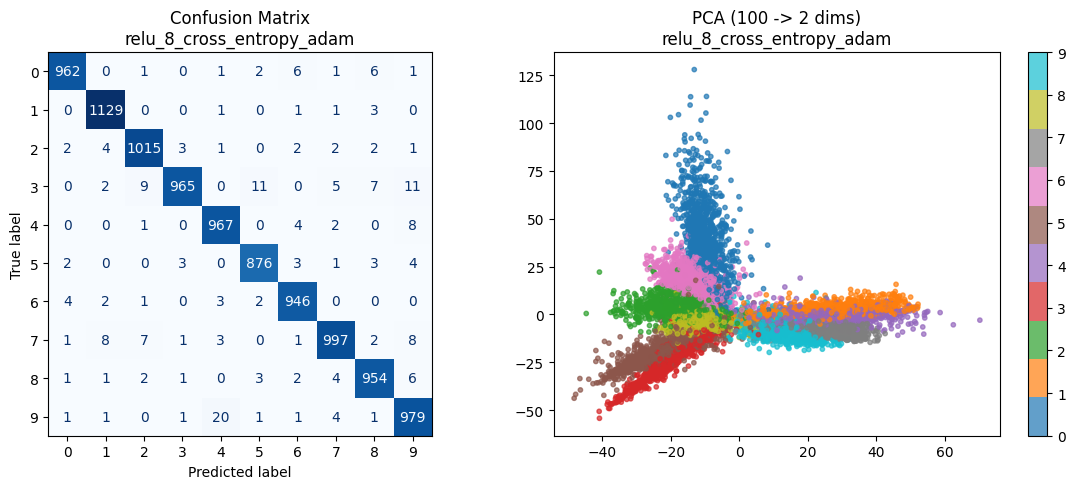

--- Case 3/16: relu_8_mse_sgd ---
  Result -> Train Acc: 97.48% | Best Valid Loss: 0.005 | Best Valid Acc: 98.18% | Test Acc: 98.29%


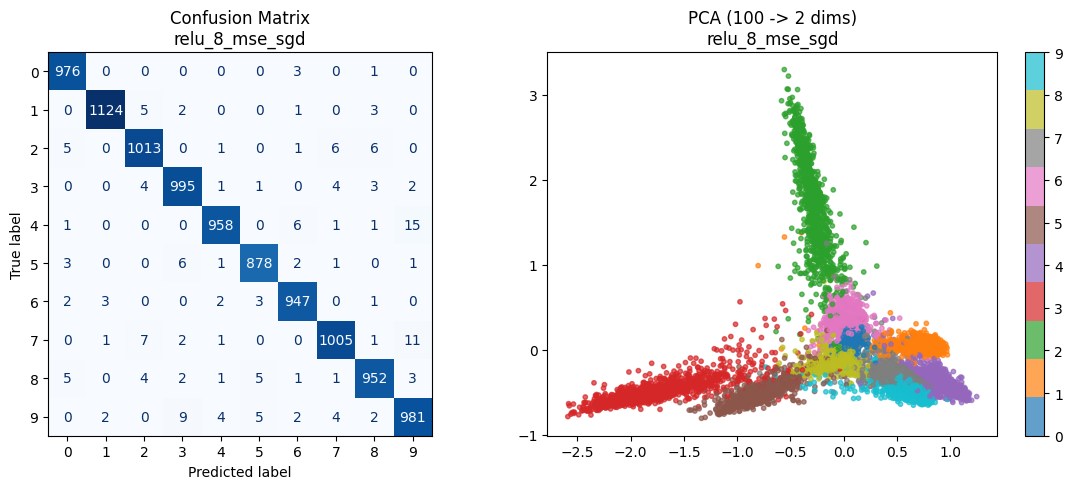

--- Case 4/16: relu_8_mse_adam ---
  Result -> Train Acc: 96.41% | Best Valid Loss: 0.005 | Best Valid Acc: 97.25% | Test Acc: 97.67%


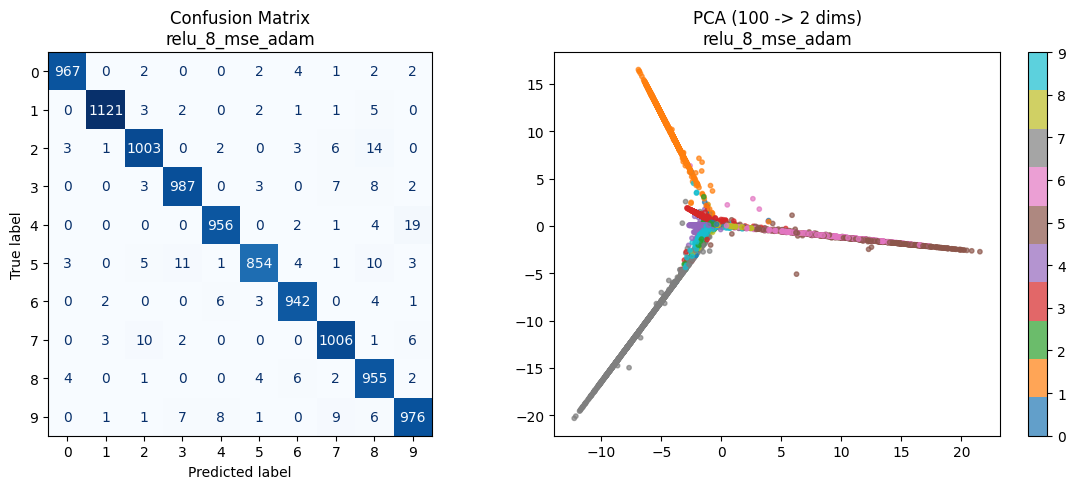

--- Case 5/16: relu_64_cross_entropy_sgd ---
  Result -> Train Acc: 97.60% | Best Valid Loss: 0.055 | Best Valid Acc: 98.38% | Test Acc: 98.27%


--- Case 6/16: relu_64_cross_entropy_adam ---
  Result -> Train Acc: 97.42% | Best Valid Loss: 0.058 | Best Valid Acc: 98.16% | Test Acc: 98.23%


--- Case 7/16: relu_64_mse_sgd ---
  Result -> Train Acc: 95.20% | Best Valid Loss: 0.010 | Best Valid Acc: 96.78% | Test Acc: 97.20%


--- Case 8/16: relu_64_mse_adam ---
  Result -> Train Acc: 97.51% | Best Valid Loss: 0.004 | Best Valid Acc: 97.84% | Test Acc: 97.97%


--- Case 9/16: sigmoid_8_cross_entropy_sgd ---
  Result -> Train Acc: 96.82% | Best Valid Loss: 0.070 | Best Valid Acc: 97.82% | Test Acc: 98.10%


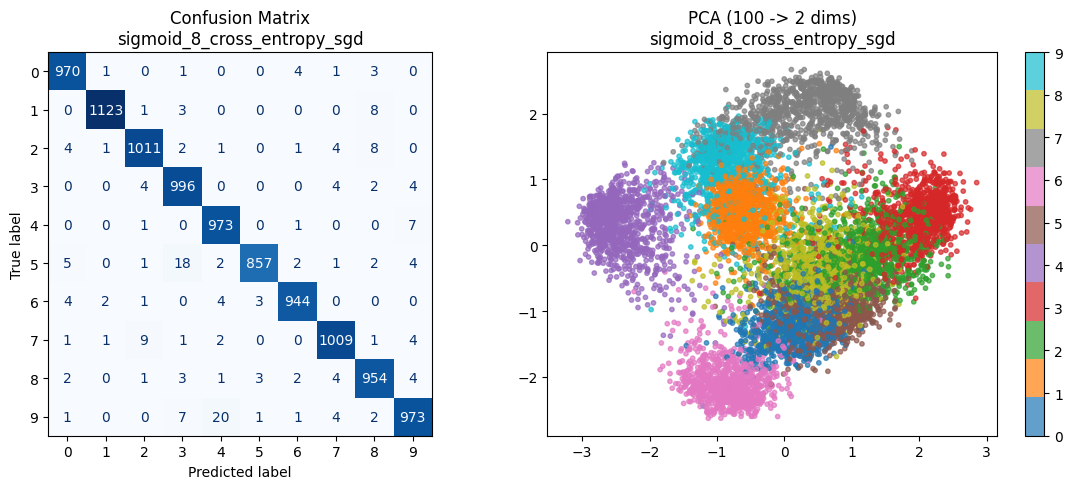

--- Case 10/16: sigmoid_8_cross_entropy_adam ---
  Result -> Train Acc: 96.42% | Best Valid Loss: 0.080 | Best Valid Acc: 97.37% | Test Acc: 97.69%


--- Case 11/16: sigmoid_8_mse_sgd ---
  Result -> Train Acc: 93.82% | Best Valid Loss: 0.014 | Best Valid Acc: 95.78% | Test Acc: 96.52%


--- Case 12/16: sigmoid_8_mse_adam ---
  Result -> Train Acc: 96.97% | Best Valid Loss: 0.004 | Best Valid Acc: 97.83% | Test Acc: 98.05%


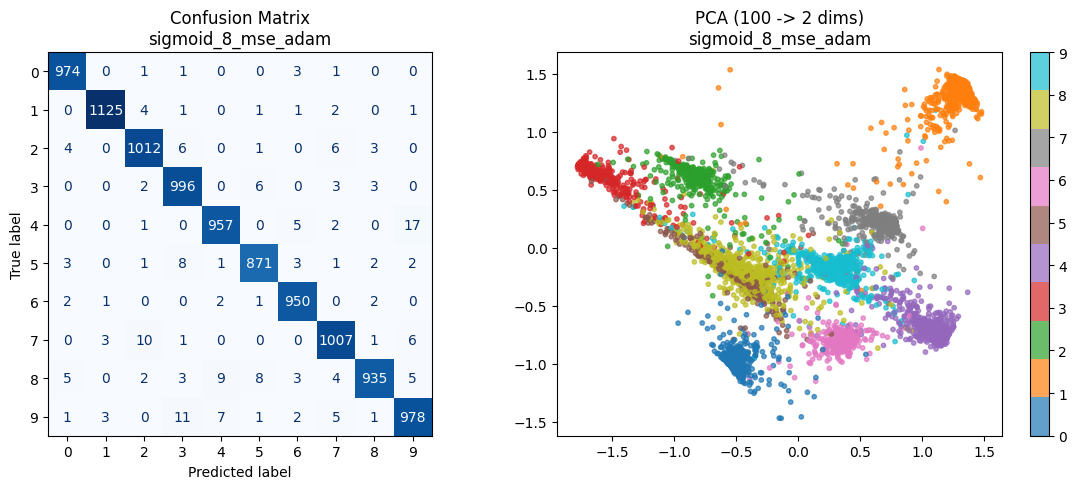

--- Case 13/16: sigmoid_64_cross_entropy_sgd ---
  Result -> Train Acc: 95.72% | Best Valid Loss: 0.105 | Best Valid Acc: 97.11% | Test Acc: 97.27%


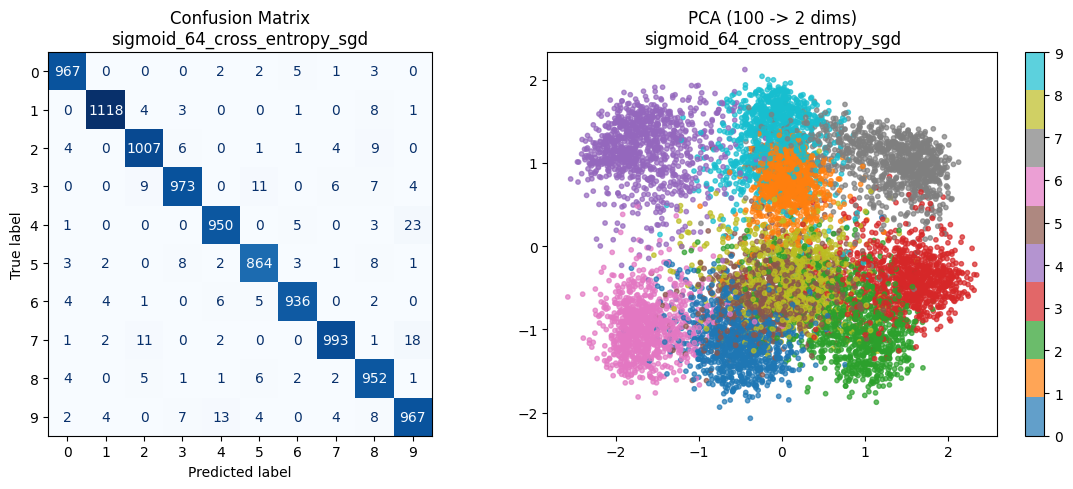

--- Case 14/16: sigmoid_64_cross_entropy_adam ---
  Result -> Train Acc: 96.81% | Best Valid Loss: 0.068 | Best Valid Acc: 97.76% | Test Acc: 97.88%


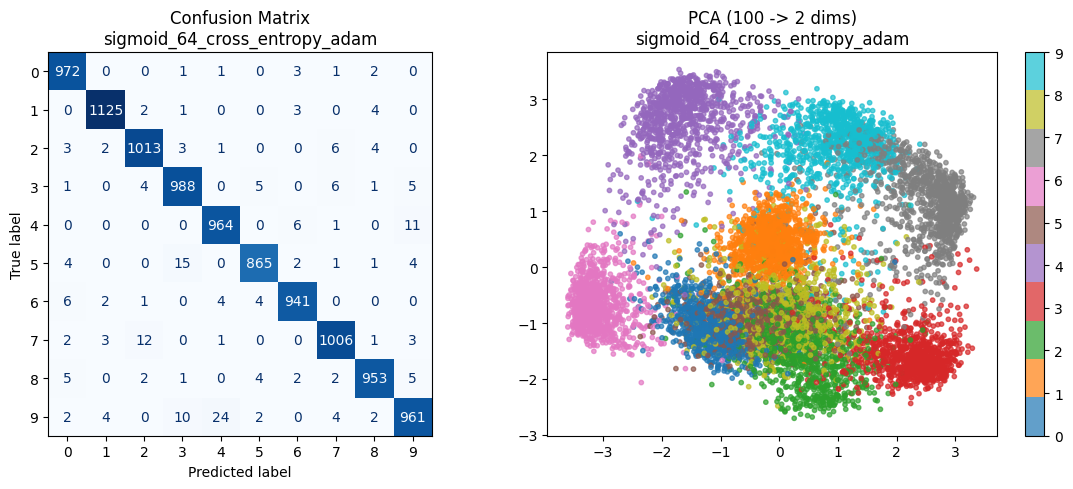

--- Case 15/16: sigmoid_64_mse_sgd ---
  Result -> Train Acc: 68.66% | Best Valid Loss: 0.046 | Best Valid Acc: 80.55% | Test Acc: 82.47%


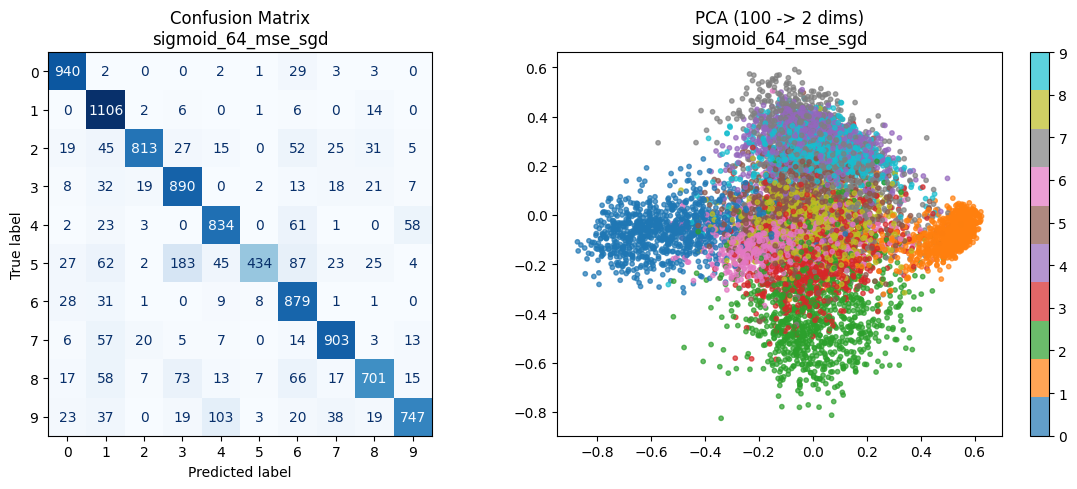

--- Case 16/16: sigmoid_64_mse_adam ---
  Result -> Train Acc: 97.20% | Best Valid Loss: 0.004 | Best Valid Acc: 97.94% | Test Acc: 98.09%


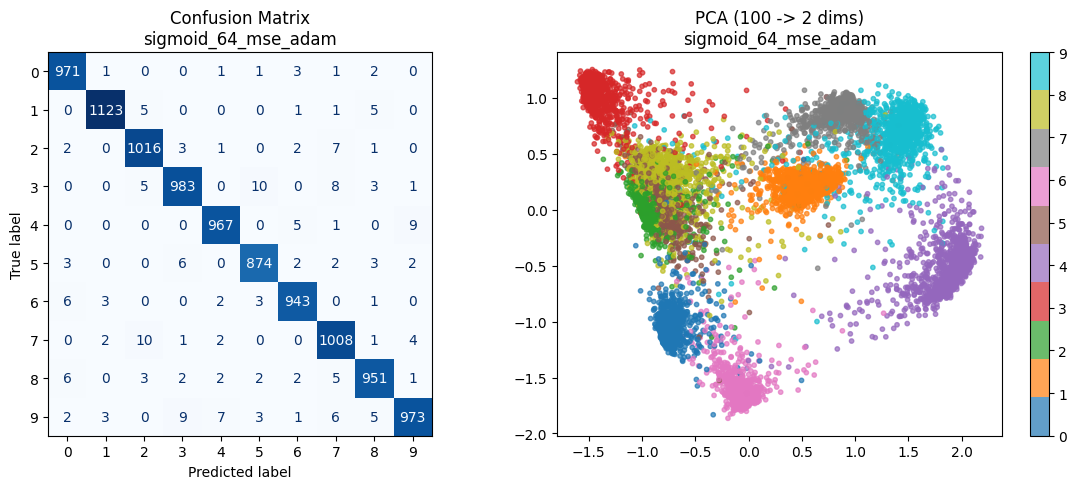

In [22]:
activations = ['relu', 'sigmoid']
batch_sizes = [8, 64]
losses = ['cross_entropy', 'mse']
optimizers = ['sgd', 'adam']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10
EPOCHS = 10
results = {}

total_cases = len(activations) * len(batch_sizes) * len(losses) * len(optimizers)
case_counter = 0

print(f"Starting experiments for {total_cases} cases...\n")

for act in activations:
    for bs in batch_sizes:
        for loss_name in losses:
            for opt_name in optimizers:
                case_counter += 1
                case_name = f"{act}_{bs}_{loss_name}_{opt_name}"
                print(f"--- Case {case_counter}/{total_cases}: {case_name} ---")

                # A. Dataloaders
                train_iterator = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=bs)
                valid_iterator = torch.utils.data.DataLoader(valid_data, batch_size=bs)
                test_iterator = torch.utils.data.DataLoader(test_data, batch_size=bs)

                # B. Creating the model
                torch.manual_seed(SEED)
                torch.cuda.manual_seed(SEED)
                np.random.seed(SEED)
                random.seed(SEED)
                model = MLP(INPUT_DIM, OUTPUT_DIM, activation_type=act).to(device)

                # C. Pick loss function
                if loss_name == 'mse':
                    criterion = nn.MSELoss().to(device)
                else:
                    criterion = nn.CrossEntropyLoss().to(device)

                # D. Pick optimizer
                if opt_name == 'sgd':
                    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
                else:
                    optimizer = optim.Adam(model.parameters(), lr=0.001)

                best_valid_loss = float('inf') # Initialize best loss for this specific case
                best_valid_acc = 0
                best_train_acc = 0
                # E. Training loop
                for epoch in range(EPOCHS):
                    train_loss, train_acc = train_epoch(model, train_iterator, optimizer, criterion, device)
                    # 2. Validate immediately after training (moved inside the loop)
                    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

                    # 3. Check if this is the best model so far
                    if valid_loss < best_valid_loss:
                        best_valid_loss = valid_loss
                        best_valid_acc = valid_acc
                        best_train_acc = train_acc
                        # Save the model weights to a temporary file
                        torch.save(model.state_dict(), 'temp_best_model.pt')

                # --- MODIFIED SECTION F: Load Best Model & Test ---

                # 1. Load the weights that gave the best validation loss
                model.load_state_dict(torch.load('temp_best_model.pt'))

                # 2. Now run the test on the BEST model, not the last epoch's model
                intermediates, labels, preds = get_test_data_for_plots(model, test_iterator, device)
                test_acc = metrics.accuracy_score(labels, preds)

                results[case_name] = test_acc

                # Print results (showing the best valid loss we found)
                print(f"  Result -> Train Acc: {best_train_acc*100:.2f}% | Best Valid Loss: {best_valid_loss:.3f} | Best Valid Acc: {best_valid_acc*100:.2f}% | Test Acc: {test_acc*100:.2f}%")

                # G. Plot the graphs
                fig, ax = plt.subplots(1, 2, figsize=(12, 5))

                # Confusion Matrix
                cm = metrics.confusion_matrix(labels, preds)
                cm_display = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
                cm_display.plot(ax=ax[0], cmap='Blues', values_format='d', colorbar=False)
                ax[0].set_title(f'Confusion Matrix\n{case_name}')

                # PCA
                pca = decomposition.PCA(n_components=2)
                pca_data = pca.fit_transform(intermediates[:])
                scatter = ax[1].scatter(pca_data[:, 0], pca_data[:, 1], c=labels[:], cmap='tab10', s=10, alpha=0.7)
                ax[1].set_title(f'PCA (100 -> 2 dims)\n{case_name}')
                fig.colorbar(scatter, ax=ax[1], ticks=range(10))

                plt.tight_layout()
                plt.show()




--- Final Comparison of All Cases ---


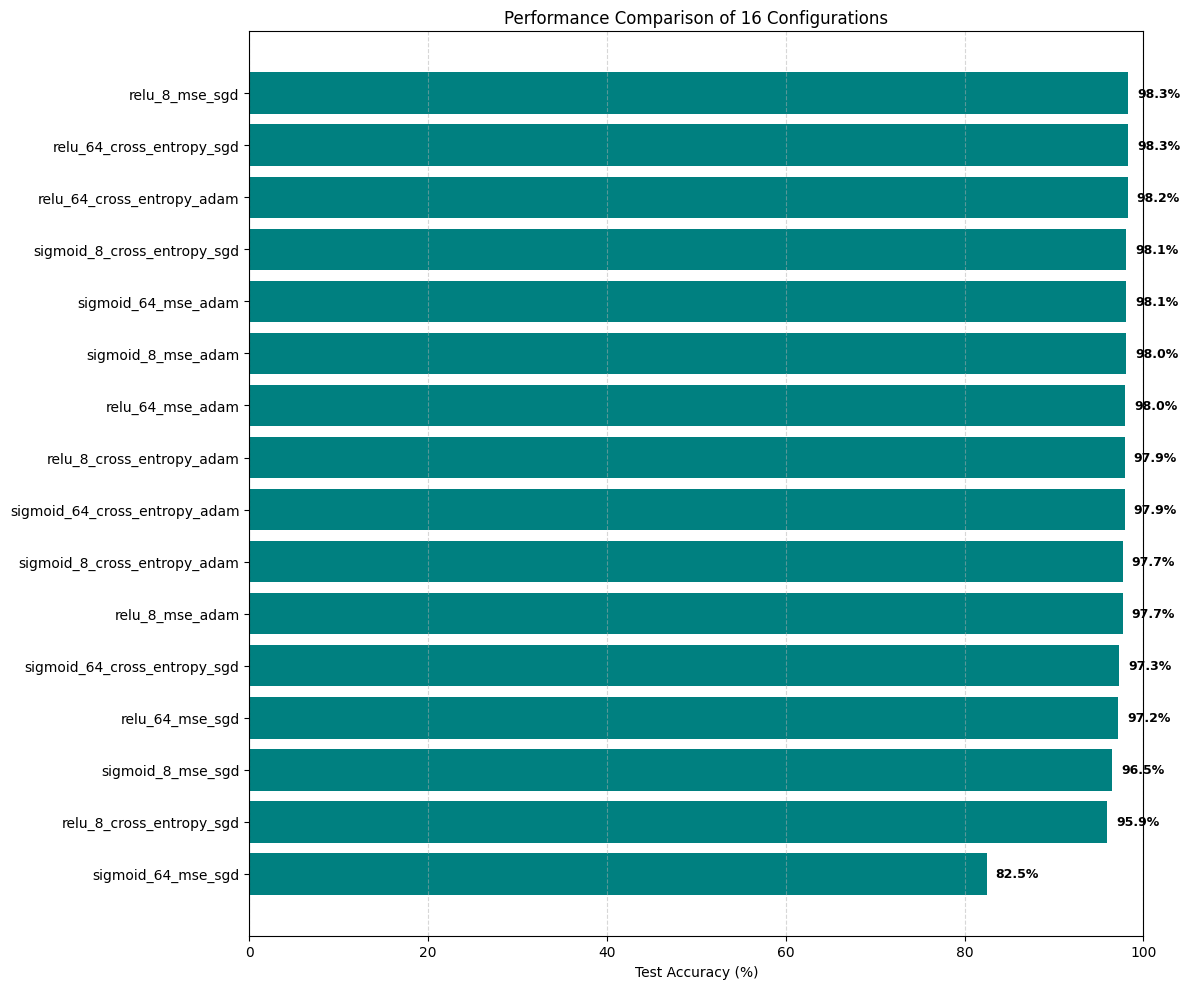

In [23]:
print("\n--- Final Comparison of All Cases ---")
plt.figure(figsize=(12, 10))

# Sort the results
sorted_results = dict(sorted(results.items(), key=lambda item: item[1]))

names = list(sorted_results.keys())
values = [v * 100 for v in sorted_results.values()]

bars = plt.barh(names, values, color='teal')
plt.xlabel('Test Accuracy (%)')
plt.title('Performance Comparison of 16 Configurations')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.xlim(0, 100)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2,
             f'{width:.1f}%', va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()